# Information Bottleneck

In [1]:
import tensorflow as tf, keras, numpy as np, matplotlib.pyplot as plt, cv2

Load the mnist dataset

In [2]:
dataset = keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = dataset
X_train, X_test = X_train/255.0, X_test/255.0 #normalize the input
y_train, y_test = keras.utils.to_categorical(y_train), keras.utils.to_categorical(y_test)

Explore the dataset

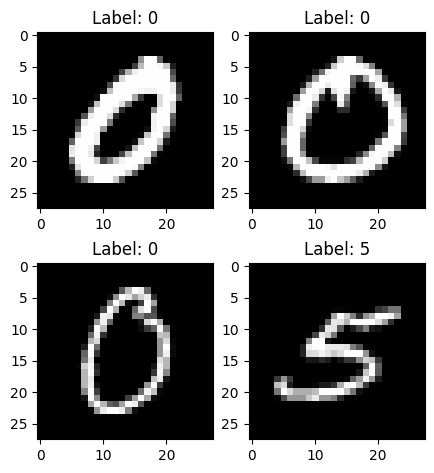

In [3]:
samples = np.random.randint(0, X_train.shape[0]+1, 4)

plt.figure(figsize = (5, 5.5))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(label = f'Label: {np.argmax(y_train[samples[i]])}')
    plt.imshow(X_train[samples[i]], cmap = 'gray')

plt.show()

VIB implementation

In [ ]:
class VIBModel(keras.Model):
    def __init__(self, latent_dim=32, beta=1e-3):
        super(VIBModel, self).__init__()
        # Encoder: Maps input to μ and log(σ²)
        self.encoder = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(256, 'relu'),
            keras.layers.Dropout(0.25),
            
            keras.layers.Dense(128, 'relu'),
            keras.layers.Dropout(0.25),
            
            keras.layers.Dense(2 * latent_dim)  # Output [μ, log_var]
        ])
        # Classifier: Maps latent z to class probabilities
        self.classifier = keras.Sequential([
            keras.layers.Dense(10, 'softmax')
        ])
        self.beta = beta
        self.optimizer = keras.optimizers.Adam()
        
    def call(self, inputs):
        # Step 1: Encoder outputs μ and log_var
        params = self.encoder(inputs)
        mean, log_var = tf.split(params, num_or_size_splits=2, axis=1)
        
        # Step 2: Reparameterization trick to sample z ~ N(μ, σ²)
        epsilon = tf.random.normal(shape=tf.shape(mean))
        z = mean + epsilon * tf.exp(0.5 * log_var)
        
        # KL Divergence (Compression)
        kl_loss = self.KL_loss(mean, log_var)
        self.add_loss(self.beta*kl_loss)
        
        # Step 3: Classify z
        y_pred = self.classifier(z)
        return y_pred, mean, log_var
    
    def train_step(self, data):
        x, y = data  # Unpack batch
        
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred, mean, log_var = self(x, training=True)
            
            # Cross-Entropy (Classification)
            ce_loss = tf.reduce_mean(
                keras.losses.categorical_crossentropy(y, y_pred)
            )
            # KL Divergence (Compression)
            kl_loss = self.KL_loss(mean, log_var)
            
            # Total Loss = CE + β*KL
            total_loss = ce_loss + self.beta * kl_loss
            
        # Compute gradients and update weights
        
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Track metrics
        return {
            "ce_loss": ce_loss,
            "kl_loss": kl_loss,
            "total_loss": total_loss,
            "accuracy": tf.reduce_mean(keras.metrics.categorical_accuracy(y, y_pred))
        }
        
    def KL_loss(self, mean, log_var):
        return tf.reduce_mean(-0.5 * tf.reduce_sum(1 + log_var-tf.square(mean) - tf.exp(log_var), axis = 1))

Model Training

In [5]:
vib_model = VIBModel(latent_dim=32, beta=1e-3)
vib_model.compile(loss = keras.losses.CategoricalCrossentropy())
# Train
history = vib_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9070 - ce_loss: 0.3048 - kl_loss: 46.2739 - total_loss: 0.3511 - val_loss: 0.2035
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9663 - ce_loss: 0.1128 - kl_loss: 39.1667 - total_loss: 0.1520 - val_loss: 0.1307
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9776 - ce_loss: 0.0747 - kl_loss: 34.1754 - total_loss: 0.1088 - val_loss: 0.1217
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9832 - ce_loss: 0.0566 - kl_loss: 31.7092 - total_loss: 0.0883 - val_loss: 0.1159
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9863 - ce_loss: 0.0451 - kl_loss: 29.7710 - total_loss: 0.0749 - val_loss: 0.1141
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9892 - ce_loss: 0.0352 - kl_loss: 27.5878 - total_loss: 0.0628 - val_loss: 0.1190
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9912 - ce_loss: 0.0291 - kl_loss: 25.7697 - to

In [6]:
y_pred, mean, log_var = vib_model.predict(X_test)
accuracy = tf.reduce_mean(keras.metrics.categorical_accuracy(y_test, y_pred))
print(accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
tf.Tensor(0.9809, shape=(), dtype=float32)


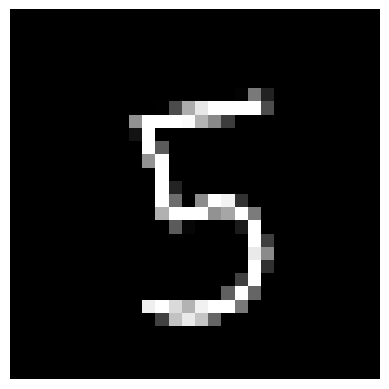

In [7]:
image = 1-cv2.resize(cv2.imread('Untitled.png', cv2.IMREAD_GRAYSCALE), (28, 28))/255.0
plt.axis('off')
plt.imshow(image, cmap = 'gray')
plt.show()

In [30]:
pred, mean, log_var = vib_model.predict(np.expand_dims(image, axis = 0))
print('Predicted label: ', np.argmax(pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicted label:  5


# Decodable Information Bottleneck

Model Implementation

In [ ]:
class DIBModel(keras.Model):
    def __init__(self, latent_dim=32, beta=1e-3, gamma = 1e-3):
        super(DIBModel, self).__init__()
        # Encoder: Maps input to μ and log(σ²)
        self.encoder = keras.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(256, 'relu'),
            keras.layers.Dropout(0.25),
            
            keras.layers.Dense(128, 'relu'),
            keras.layers.Dropout(0.25),
            
            keras.layers.Dense(2 * latent_dim)  # Output [μ, log_var]
        ])
        # Classifier: Maps latent z to class probabilities
        self.classifier = keras.Sequential([
            keras.layers.Dense(10, 'softmax')
        ])
        
        # Decoder: Maps latent z back to the input (reconstructs the input from z) 
        self.decoder = keras.Sequential([
            keras.layers.Dense(128, 'relu'),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(256, 'relu'),
            keras.layers.Dropout(0.25),
            keras.layers.Dense(28*28, 'sigmoid'),
            keras.layers.Reshape(target_shape = (28, 28, 1))
        ])
        self.beta = beta
        self.gamma = gamma
        self.optimizer = keras.optimizers.Adam()
        
    def call(self, inputs):
        # Step 1: Encoder outputs μ and log_var
        params = self.encoder(inputs)
        mean, log_var = tf.split(params, num_or_size_splits=2, axis=1)
        
        # Step 2: Reparameterization trick to sample z ~ N(μ, σ²)
        epsilon = tf.random.normal(shape=tf.shape(mean))
        z = mean + epsilon * tf.exp(0.5 * log_var)
        
        # KL Divergence (Compression)
        kl_loss = self.KL_loss(mean, log_var)
        self.add_loss(self.beta*kl_loss)
        
        # Reconstruction loss
        x_recon = self.decoder(z)
        recon_loss = tf.reduce_mean(keras.losses.mean_squared_error(inputs, x_recon))
        self.add_loss(self.gamma*recon_loss)
        
        
        # Step 3: Classify z
        y_pred = self.classifier(z)
        return y_pred, x_recon, mean, log_var
    
    def train_step(self, data):
        x, y = data  # Unpack batch
        
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred, x_recon, mean, log_var = self(x, training=True)
            
            # Cross-Entropy (Classification)
            ce_loss = tf.reduce_mean(
                keras.losses.categorical_crossentropy(y, y_pred)
            )
            # KL Divergence (Compression)
            kl_loss = self.KL_loss(mean, log_var)
            
            # Reconstruction loss
            recon_loss = tf.reduce_mean(keras.losses.mean_squared_error(x, x_recon))
            # Total Loss = CE + β*KL + 𝛾*reconstruction
            total_loss = ce_loss + self.beta * kl_loss + self.gamma * recon_loss
            
        # Compute gradients and update weights
        
        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # Track metrics
        return {
            "ce_loss": ce_loss,
            "kl_loss": kl_loss,
            "recon_loss" : recon_loss,
            "total_loss": total_loss,
            "accuracy": tf.reduce_mean(keras.metrics.categorical_accuracy(y, y_pred))
        }
        
    def KL_loss(self, mean, log_var):
        return tf.reduce_mean(-0.5 * tf.reduce_sum(1 + log_var-tf.square(mean) - tf.exp(log_var), axis = 1))

Model Training

In [26]:
gamma = 1.5
dib_model = DIBModel(latent_dim=32, beta=1e-3, gamma = gamma)
dib_model.compile(loss = keras.losses.CategoricalCrossentropy())
# Train
history = dib_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=128,
    validation_data=(X_test, y_test)
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9071 - ce_loss: 0.3068 - kl_loss: 50.1813 - recon_loss: 0.0598 - total_loss: 0.4467 - val_loss: 0.2620
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9670 - ce_loss: 0.1115 - kl_loss: 42.2398 - recon_loss: 0.0470 - total_loss: 0.2242 - val_loss: 0.2029
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9779 - ce_loss: 0.0737 - kl_loss: 39.5369 - recon_loss: 0.0425 - total_loss: 0.1770 - val_loss: 0.1762
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9830 - ce_loss: 0.0548 - kl_loss: 37.2167 - recon_loss: 0.0399 - total_loss: 0.1519 - val_loss: 0.1674
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9874 - ce_loss: 0.0415 - kl_loss: 35.8432 - recon_loss: 0.0380 - total_loss: 0.1343 - val_loss: 0.1570
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9895 - ce_loss: 0.0340 - kl_loss: 34.2999 - recon_loss: 0.0365 - total_loss: 0.1230 - val

In [27]:
y_pred, x_recon, mean, log_var = dib_model.predict(X_test)
accuracy = tf.reduce_mean(keras.metrics.categorical_accuracy(y_test, y_pred))
print(accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
tf.Tensor(0.9826, shape=(), dtype=float32)


In [28]:
y_pred, x_recon, mean, log_var = dib_model.predict(np.expand_dims(image, axis = 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


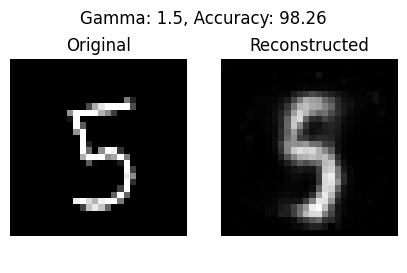

In [29]:
plt.figure(figsize = (5, 3))
plt.axis('off')
plt.title(f'Gamma: {gamma}, Accuracy: {round(float(accuracy.numpy()) * 100, 3)}')

plt.subplot(1, 2, 1)
plt.title('Original')
plt.axis('off')
plt.imshow(image, cmap = 'gray')

plt.subplot(1, 2, 2)
plt.title(f'Reconstructed')
plt.axis('off')
plt.imshow(x_recon[0], cmap = 'gray')

plt.show()